In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

## Plot the experimental, initial simulation and iterated simulation curves

In [55]:
def plotSimulations(initialSims, pathExp, pathSim, title, CPLaw, plotIterations = False):
    plt.figure(figsize=(16,10))
    # The simulation curves from DAMASK are in true stress-true strain
    # preprocess them into flow curves in order to compare with the experimental curve
    initial_data = np.load(f'{pathSim}/initial_simulations.npy', allow_pickle=True)
    initial_data = initial_data.tolist()
    if CPLaw == "PH":
        convertUnit = 1
    elif CPLaw == "DB":
        convertUnit = 1e-6
    if plotIterations:
        full_data = np.load(f'{pathSim}/simulations.npy', allow_pickle=True)
        full_data = full_data.tolist()
    
    for curve in initial_data.values():
        trueStress = curve[1] * convertUnit
        truePlasticStrain = curve[0] 
        plt.plot(truePlasticStrain, trueStress, c='orange', alpha=0.2)
    plt.plot(truePlasticStrain, trueStress, label = f"Initial simulations x{initialSims}",c='orange', alpha=0.2)
    allstrains = list(map(lambda x: x[0], list(initial_data.values())))
    simStrain = np.array(allstrains).mean(axis=0)

    exp_curve = pd.read_csv(pathExp)
    exp_stress = exp_curve.iloc[:,0] * convertUnit # Getting the experimental stress
    exp_strain = exp_curve.iloc[:,1] # Getting the experimental strain
    plt.plot(exp_strain, exp_stress, label = f"Experimental curve")

    interpolatedFunction = interp1d(exp_strain, exp_stress) # interpolated function fits the experimental data
    # The common strain points of experimental and simulated curves will be lying between 0.002 (strain of yield stress)
    # and the maximum strain value of experimental curve 
    x_min, x_max = 0.002, exp_strain.max() 
    # prune will be a list of True and False, which indicate which index of the strain to choose from
    prune = np.logical_and(simStrain > x_min, simStrain < x_max)
    # sim.strain is the average strains of the initial simulations 
    # Therefore sim.strain is the same for all simulated curves. Now it is pruned
    simStrain = simStrain[prune]
    # exp_target is now the refined experimental stress values for comparison such as fitness and MSE, 
    # after being pruned and interpolated at the pruned simulated stress values
    exp_target = interpolatedFunction(simStrain).reshape(-1) 

    if plotIterations:
        parameters = list(full_data)[initialSims:]
        strainstress = list(full_data.values())[initialSims:]
        simCurves = zip(parameters, strainstress)
        i = 0
        for parameter, strainstress in simCurves:
            trueStress = strainstress[1] * convertUnit
            truePlasticStrain = strainstress[0]
            i += 1
            plt.plot(truePlasticStrain, trueStress, label = f"Iteration {i}: {parameter}")

    # Uncomment these lines to have a closer view. Change the limit as you want to see better
    plt.xlim([0,0.2])
    plt.ylim([0,250])
    plt.title(title)
    plt.xlabel(xlabel = "Strain (-)")
    plt.ylabel(ylabel = "Stress (MPa)")
    plt.legend(loc=2, prop={'size': 12})
    plt.show()
    return simStrain, exp_target


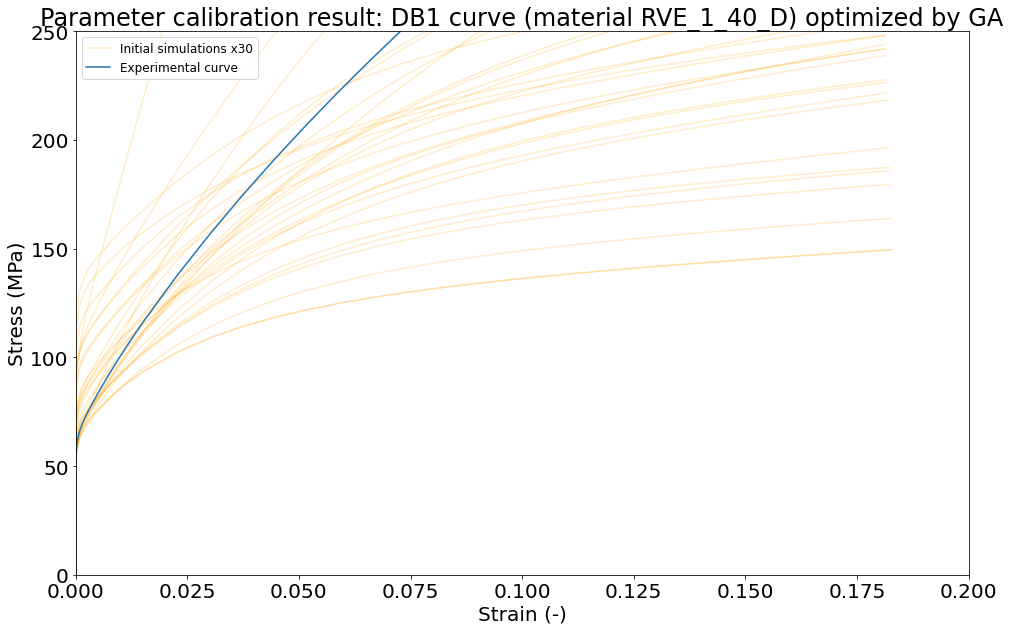

In [56]:
# Please change these configurations
# Number of initial simulations
initialSims = 30

# material used
material = "RVE_1_40_D"
# material = "512grains512"

# Used algorithm
algorithm = "GA"
# algorithm = "BA"

# Crystal plasticity law
# CPLaw = "PH"
CPLaw = "DB"

# Curve index
curveIndex = 1
# curveIndex = 2
# curveIndex = 3

title = f"Parameter calibration result: {CPLaw}{curveIndex} curve (material {material}) optimized by {algorithm}"
pathExp = f"targets_{material}/{CPLaw}{curveIndex}.csv"
pathSim = f"results_{material}/{CPLaw}{curveIndex}_{algorithm}"

# Plot only initial simulations and experimental curve
simStrain, exp_target = plotSimulations(initialSims, pathExp, pathSim, title, CPLaw)
# Plot initial simulations, experimental curve and iterated simulation results
# simStrain, exp_target = plotSimulations(initialSims, pathExp, pathSim, title, CPLaw, True)

## Plot fitness for the curves

In [5]:
def D1(exp_stress, sim_stress): 
    return np.sqrt(np.sum(np.square(exp_stress - sim_stress))/np.sum(np.square(exp_stress)))

def D2(exp_stress, sim_stress, sim_strain): 
    exp_stress_d1 = np.diff(exp_stress)/np.diff(sim_strain)  
    sim_stress_d1 = np.diff(sim_stress)/np.diff(sim_strain)
    return np.sqrt(np.sum(np.square(sim_stress_d1 - exp_stress_d1))/np.sum(np.square(exp_stress_d1)))

def D3(exp_stress, sim_stress):
    return np.max(np.sqrt(np.square(exp_stress - sim_stress)/sum(np.square(exp_stress))))

def D4(exp_stress, sim_stress, sim_strain):
    exp_stress_d1 = np.diff(exp_stress)/np.diff(sim_strain)
    sim_stress_d1 = np.diff(sim_stress)/np.diff(sim_strain)
    return np.max(np.sqrt(np.square(sim_stress_d1 - exp_stress_d1)/np.sum(np.square(exp_stress_d1))))

def fitness_hardening(exp_stress, sim_stress, sim_strain, w1, w2, w3, w4):
    return ( w1*D1(exp_stress, sim_stress) + w2*D2(exp_stress, sim_stress, sim_strain) 
            + w3*D3(exp_stress, sim_stress) + w4*D4(exp_stress, sim_stress, sim_strain))

w1 = 0.9
w2 = 0.005
w4 = 0.009
w3 = 1 - w1 - w2 - w4

In [6]:
# D1 loss function: L2 loss 
plt.rc('font', size=20)          # controls default text sizes

# Results of each objective functions
resD1 = []
resD2 = []
resD3 = []
resD4 = []
res_fit = []

# Please change this manually
numberOfGen = 7

# Fix this labels for the correct number of generations
labelsModel = ['1st Iteration', '2nd Iteration', '3rd Iteration', '4th Iteration','5th Iteration', 
          '6th Iteration', '7th Iteration', '8th Iteration', '9th Iteration', '10th Iteration', ]
labels = labelsModel[:numberOfGen]
# labels = ['1st Generation', '2nd Generation']
full_data = np.load(f'{pathSim}/simulations.npy', allow_pickle=True)
full_data = full_data.tolist()
parameters = list(full_data)[initialSims:]
strainstress = list(full_data.values())[initialSims:]
simCurves = zip(parameters, strainstress)

for parameter, strainstress in simCurves:
    trueStress = strainstress[1]
    truePlasticStrain = strainstress[0]
    interpolatedSimStressFunction = interp1d(truePlasticStrain, trueStress)
    sim_stress = interpolatedSimStressFunction(simStrain)
    resD1.append(D1(exp_target, sim_stress))
    resD2.append(D2(exp_target, sim_stress, simStrain))
    resD3.append(D3(exp_target, sim_stress))
    resD4.append(D4(exp_target, sim_stress, simStrain))
    
    res_fit.append(fitness_hardening(exp_target, sim_stress, simStrain, w1, w2, w3, w4))

print("D1 is: ")
print(resD1)
print("D2 is: ")
print(resD2)
print("D3 is: ")
print(resD3)
print("D4 is: ")
print(resD4)

width = 0.55       # the width of the bars: can also be len(x) sequence
L1 = np.array(resD1)[-numberOfGen:]*w1
L2 = np.array(resD2)[-numberOfGen:]*w2
L3 = np.array(resD3)[-numberOfGen:]*w3
L4 = np.array(resD4)[-numberOfGen:]*w4

print("L1 is: ")
print(resD1)
print("L2 is: ")
print(resD2)
print("L3 is: ")
print(resD3)
print("L4 is: ")
print(resD4)

ValueError: A value in x_new is above the interpolation range.

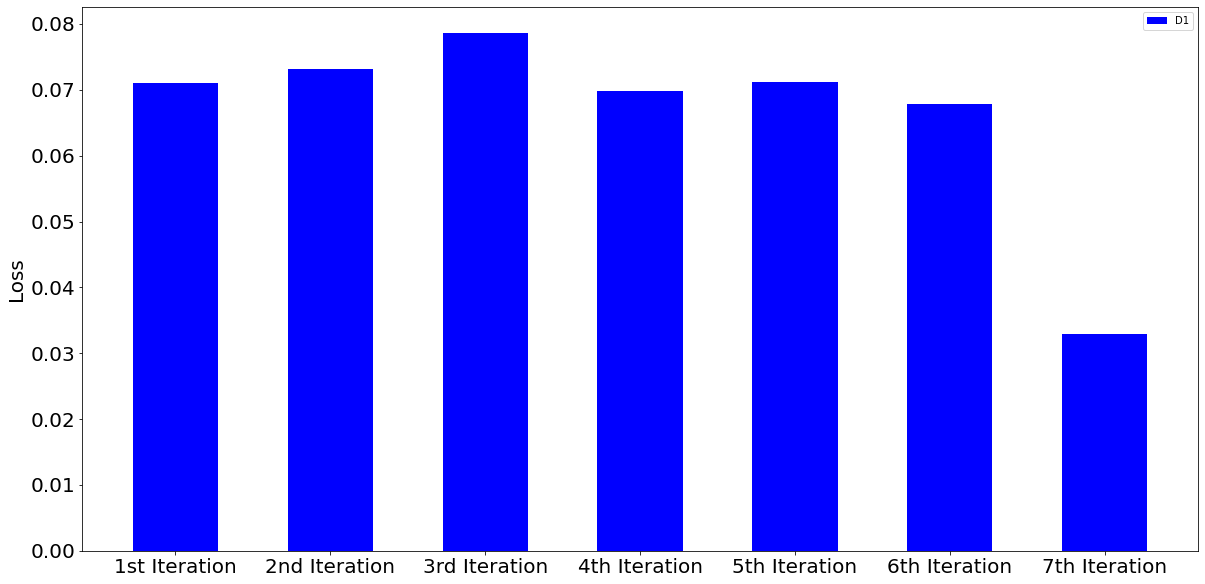

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, L1, width, label='D1', color = "blue")
ax.set_ylabel('Loss',size=20)
ax.legend(prop={'size': 10})
plt.show()

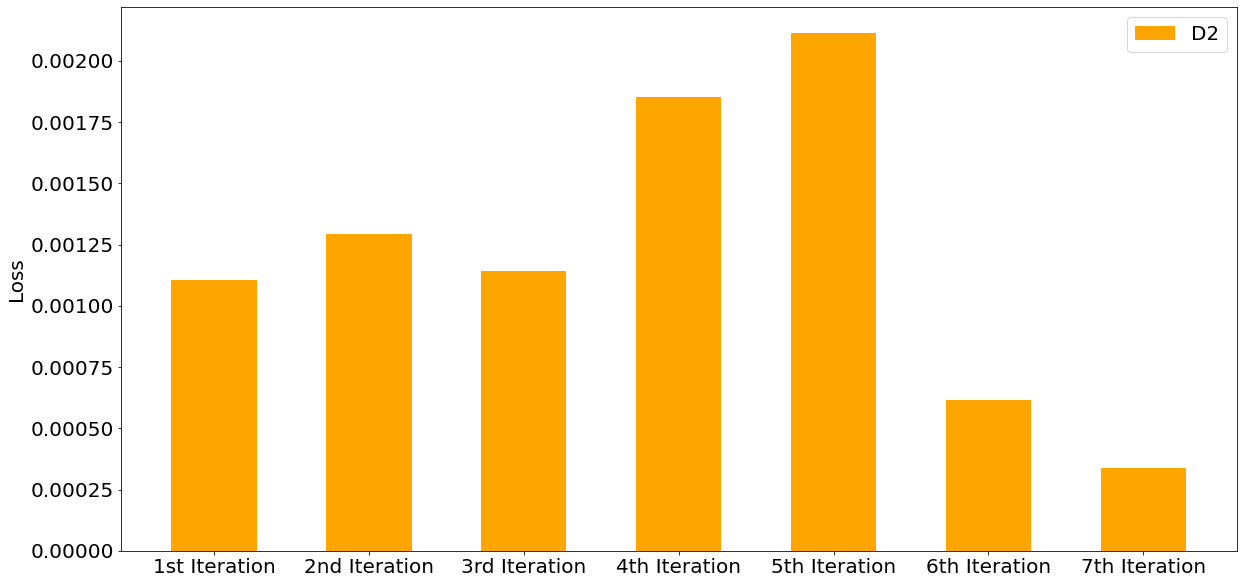

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, L2, width, label='D2', color = "orange")
ax.set_ylabel('Loss',size=20)
ax.legend(prop={'size': 20})
plt.show()

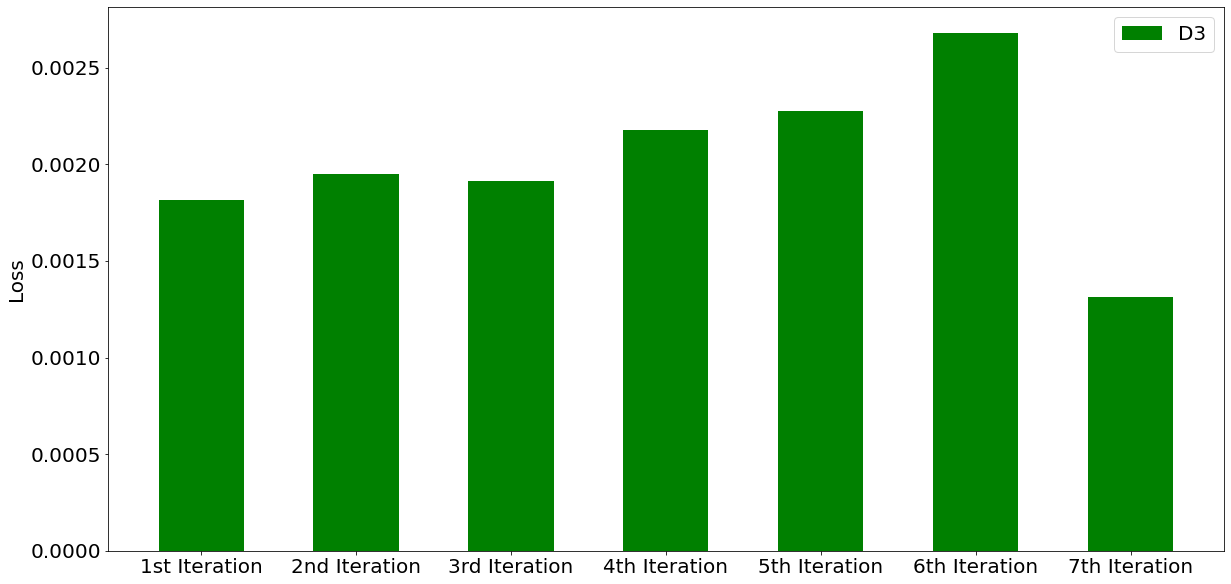

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, L3, width, label='D3', color = "green")
ax.set_ylabel('Loss',size=20)
ax.legend(prop={'size': 20})
plt.show()

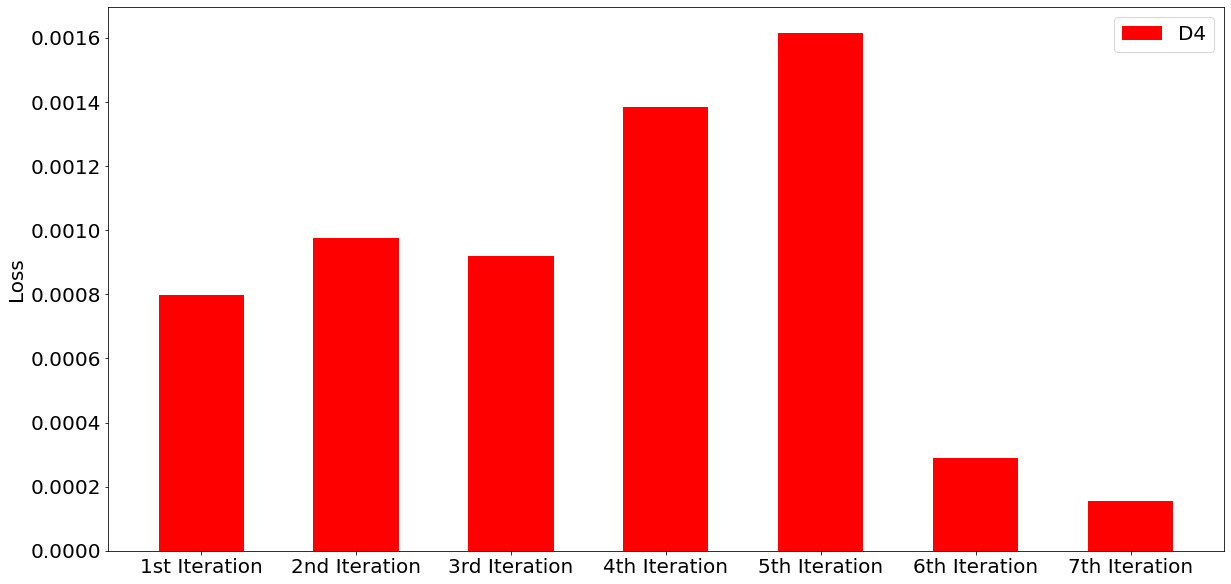

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, L4, width, label='D4', color = "red")
ax.set_ylabel('Loss',size=20)
ax.legend(prop={'size': 20})
plt.show()

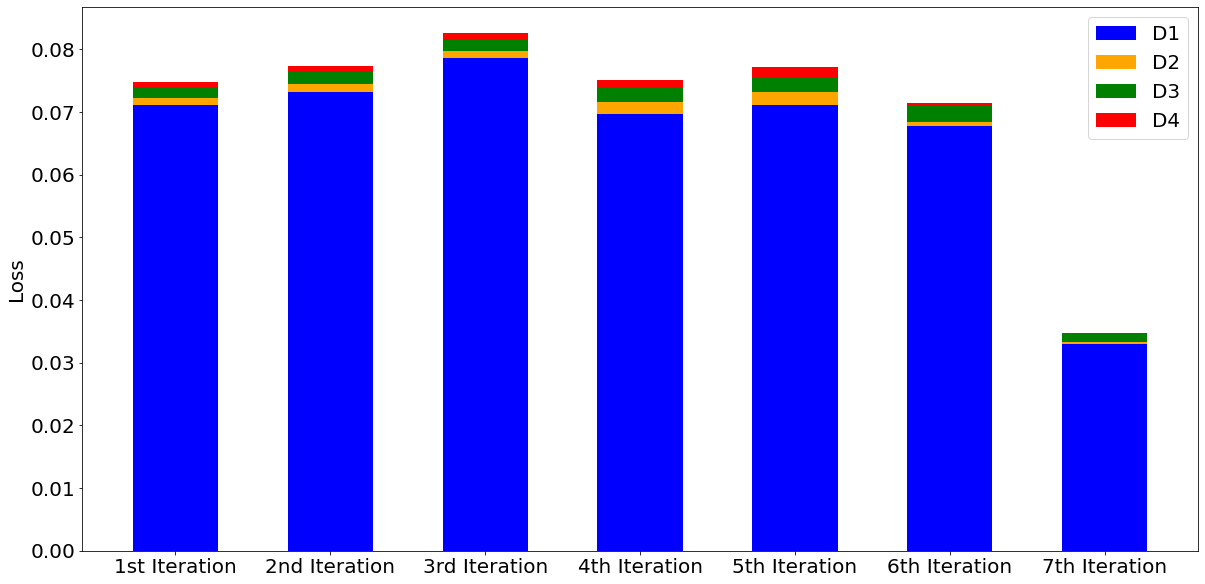

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, L1, width, label='D1', color = "blue")
ax.bar(labels, L2, width, bottom=L1 , label='D2', color = "orange")
ax.bar(labels, L3, width, bottom=L1+L2, label='D3', color = "green")
ax.bar(labels, L4, width, bottom=L1+L2+L3, label='D4', color = "red")

#plt.hlines(res_fit[2], xmin=-0.55, xmax=4.55, linestyles='dashed')
ax.set_ylabel('Loss',size=20)
ax.legend(prop={'size': 20})
plt.show()

## Interpolated points plot

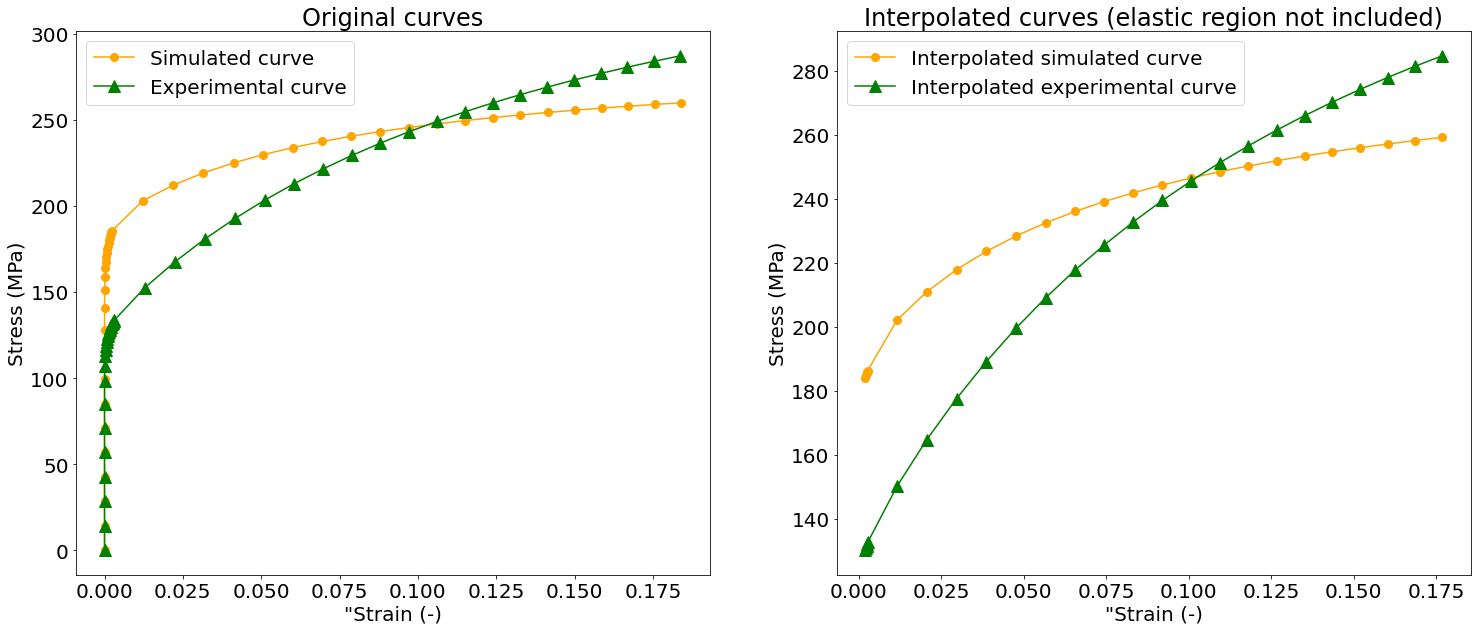

In [ ]:
def plotInterpolate(initialSims, pathExp, pathSim):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    # The simulation curves from DAMASK are in true stress-true strain
    # preprocess them into flow curves in order to compare with the experimental curve
    initial_data = np.load(f'{pathSim}/initial_simulations.npy', allow_pickle=True)
    initial_data = initial_data.tolist()
    
    simCurve = list(initial_data.values())[0]
    trueStress = simCurve[1]
    truePlasticStrain = simCurve[0]
    ax1.plot(truePlasticStrain, trueStress, label = f"Simulated curve",c='orange', marker='.', markersize=16)
    allstrains = list(map(lambda x: x[0], list(initial_data.values())))
    simStrain = np.array(allstrains).mean(axis=0)

    exp_curve = pd.read_csv(pathExp)
    exp_stress = exp_curve.iloc[:,0] # Getting the experimental stress
    exp_strain = exp_curve.iloc[:,1] # Getting the experimental strain
    ax1.plot(exp_strain, exp_stress, label = f"Experimental curve", c="green", marker='^', markersize=12)

    interpolatedFunction = interp1d(exp_strain, exp_stress) # interpolated function fits the experimental data
    # The common strain points of experimental and simulated curves will be lying between 0.002 (strain of yield stress)
    # and the maximum strain value of experimental curve 
    x_min, x_max = 0.002, exp_strain.max() 
    # prune will be a list of True and False, which indicate which index of the strain to choose from
    prune = np.logical_and(simStrain > x_min, simStrain < x_max)
    # sim.strain is the average strains of the initial simulations 
    # Therefore sim.strain is the same for all simulated curves. Now it is pruned
    simStrain = simStrain[prune]
    # exp_target is now the refined experimental stress values for comparison such as fitness and MSE, 
    # after being pruned and interpolated at the pruned simulated stress values
    exp_target = interpolatedFunction(simStrain).reshape(-1)
    interpolatedFunction = interp1d(truePlasticStrain, trueStress)
    sim_target = interpolatedFunction(simStrain).reshape(-1)
    ax2.plot(simStrain, sim_target, label = f"Interpolated simulated curve", c="orange", marker='.', markersize=16) 
    ax2.plot(simStrain, exp_target, label = f"Interpolated experimental curve", c="green", marker='^', markersize=12) 

    '''
    if plotIterations:
        parameters = list(full_data)[initialSims:]
        strainstress = list(full_data.values())[initialSims:]
        simCurves = zip(parameters, strainstress)
        i = 0
        for parameter, strainstress in simCurves:
            trueStress = strainstress[1]
            truePlasticStrain = strainstress[0]
            i += 1
            plt.plot(truePlasticStrain, trueStress, label = f"Iteration {i}: {parameter}")
        lastIterSimStress = trueStress
        lastIterSimStrain = truePlasticStrain
        interpolatedSimStressFunction = interp1d(lastIterSimStrain, lastIterSimStress)
        interpolatedSimStress = interpolatedSimStressFunction(simStrain)
        loss = mean_squared_error(interpolatedSimStress, exp_target)
        print("MSE == ", loss)
    '''

    ax1.set_title('Original curves')
    ax1.set(xlabel='"Strain (-)', ylabel='Stress (MPa)')
    ax1.legend(loc=2, prop={'size': 20})
    ax2.set_title('Interpolated curves (elastic region not included)')
    ax2.set(xlabel='"Strain (-)', ylabel='Stress (MPa)')
    ax2.legend(loc=2, prop={'size': 20})
    plt.show()

plotInterpolate(initialSims, pathExp, pathSim)
